In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=True)

In [8]:
# reflect an existing database into a new model
Base_Model  = automap_base()
# reflect the tables
Base_Model.prepare(engine, reflect=True)

2024-02-29 13:12:29,632 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-02-29 13:12:29,633 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-02-29 13:12:29,636 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-02-29 13:12:29,640 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2024-02-29 13:12:29,641 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-02-29 13:12:29,643 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("measurement")
2024-02-29 13:12:29,644 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-02-29 13:12:29,648 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("station")
2024-02-29 13:12:29,649 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-02-29 13:12:29,653 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name

C:\Users\ahsun\AppData\Local\Temp\ipykernel_18648\408277635.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base_Model.prepare(engine, reflect=True)


In [9]:
# View all of the classes that automap found
Base_Model.classes.keys()

['station', 'measurement']

In [10]:
# Save references to each table

Station = Base_Model.classes.station
Measurement = Base_Model.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.

most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

most_recent_date

2024-02-29 13:38:08,612 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-02-29 13:38:08,627 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date 
FROM measurement ORDER BY measurement.date DESC
 LIMIT ? OFFSET ?
2024-02-29 13:38:08,629 INFO sqlalchemy.engine.Engine [generated in 0.00150s] (1, 0)


('2017-08-23',)

2016-08-23
2024-02-29 13:43:21,935 INFO sqlalchemy.engine.Engine SELECT measurement.date AS measurement_date, measurement.prcp AS measurement_prcp 
FROM measurement 
WHERE measurement.date >= ? AND measurement.prcp IS NOT NULL ORDER BY measurement.date
2024-02-29 13:43:21,936 INFO sqlalchemy.engine.Engine [cached since 201.7s ago] ('2016-08-23',)


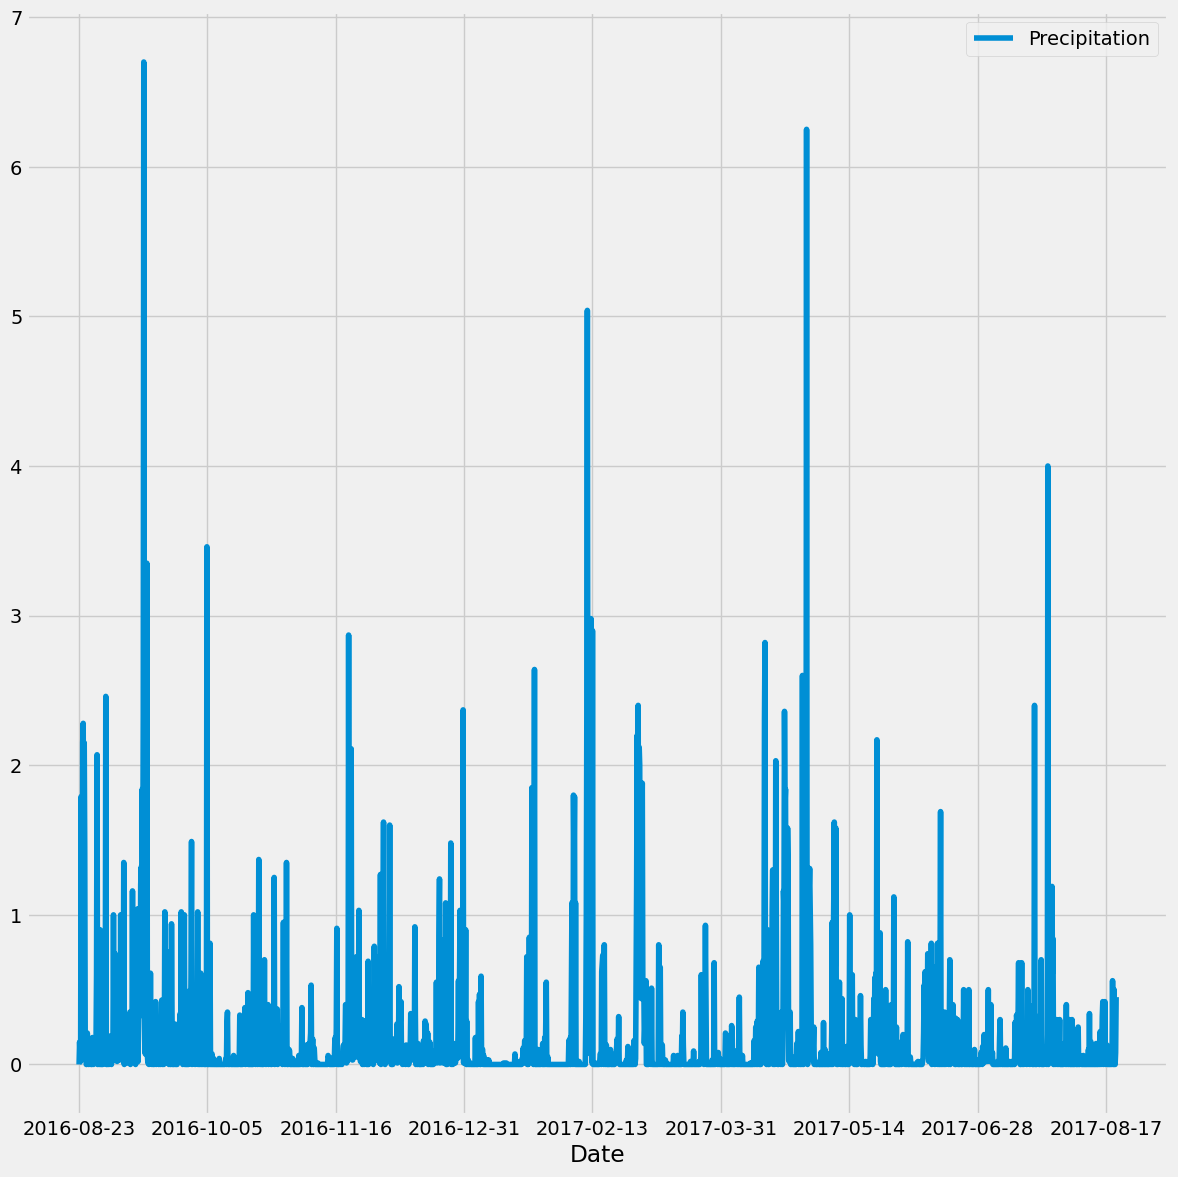

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)

print(year_ago)

# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago, Measurement.prcp != None).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dataframe = pd.DataFrame(year_prcp, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
dataframe.set_index('Date', inplace=True)
dataframe.head()

# Use Pandas Plotting with Matplotlib to plot the data
dataframe.plot(figsize=(12,12))

plt.tight_layout()

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
dataframe.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

2024-02-29 14:00:12,941 INFO sqlalchemy.engine.Engine SELECT count(*) AS count_1 
FROM (SELECT DISTINCT measurement.station AS measurement_station 
FROM measurement) AS anon_1
2024-02-29 14:00:12,943 INFO sqlalchemy.engine.Engine [generated in 0.00180s] ()


9

In [22]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()

most_active_stations

2024-02-29 14:01:20,846 INFO sqlalchemy.engine.Engine SELECT measurement.station AS measurement_station, count(measurement.station) AS count_1 
FROM measurement GROUP BY measurement.station ORDER BY count(measurement.station) DESC
2024-02-29 14:01:20,849 INFO sqlalchemy.engine.Engine [generated in 0.00205s] ()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
calculations = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()

calculations

2024-02-29 14:02:35,203 INFO sqlalchemy.engine.Engine SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = ? ORDER BY min(measurement.tobs)
2024-02-29 14:02:35,204 INFO sqlalchemy.engine.Engine [generated in 0.00163s] ('USC00519281',)


[(54.0, 85.0, 71.66378066378067)]

2024-02-29 16:23:32,054 INFO sqlalchemy.engine.Engine SELECT measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?
2024-02-29 16:23:32,055 INFO sqlalchemy.engine.Engine [cached since 154.5s ago] ('USC00519281', '2017,8,23')


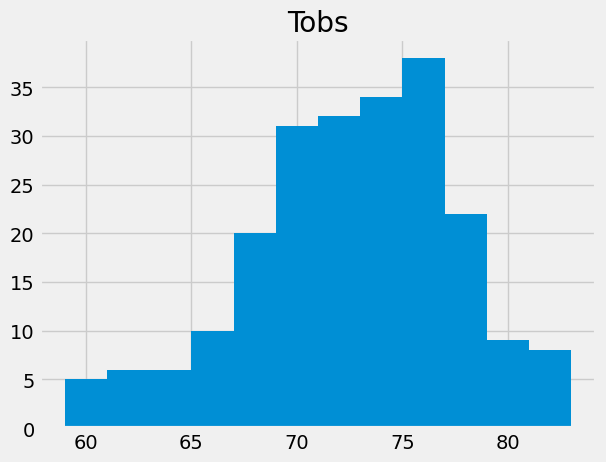

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_year =  session.query(Measurement.tobs).\
                          filter(Measurement.station == 'USC00519281' ).\
                          filter(Measurement.date >= '2017,8,23').all()



dataframe_last_year = pd.DataFrame(last_year , columns = ['Tobs'])


dataframe_last_year.hist( bins = 12)

plt.show()


# Close Session

In [16]:
# Close Session
session.close()